# Configuration

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import seaborn as sns
import simplejson as json
import os
from datetime import timedelta
import webbrowser
import papermill as pm
from enum import Enum
import re
import simplejson as json

In [46]:
%env GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json
client = bigquery.Client()

env: GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json


# Create feature table in bigquery

In [50]:
number_of_addresses = 10000

# format: dd.mm.yyyy
observation_period_start = "2020-01-01 00:00:00+00"
observation_period_end = "2020-02-01 00:00:00+00"

class ADDRESS_SELECTION(Enum):
    RANDOM = 1 # selects random addresses, that have been active within the observation period.
    RICHEST = 2 # selects the accounts that have the most ether # not yet implemented
    HIGHEST_TURNOVER = 3 # selects the accounts that have the most ether received + sent

address_selection = ADDRESS_SELECTION.HIGHEST_TURNOVER.value

# max USD amount to spent for executing sql queries
max_bigquery_costs_usd = 2

# Delete existing tables
reset = True

In [ ]:
try:
    pm.execute_notebook(
       './bigquery/features.ipynb',
       './bigquery/build/features.build.ipynb',
       parameters = dict(observation_period_start=observation_period_start,observation_period_end=observation_period_end, address_selection=address_selection,max_bigquery_costs_usd=max_bigquery_costs_usd, reset = reset),
       cwd = "./bigquery"
    )
except Exception as e:
    if "does already exist" in e.args[0]:
        print("Feature table does already exist.")
        pass
    else:
        raise

# Load feature table from bigquery

In [6]:
current_view_name = "features"
current_table_id = "{}_{}_{}_{}_{}_view".format(current_view_name, ADDRESS_SELECTION(address_selection).name, number_of_addresses, re.sub(r'[-.+: ]', '_', observation_period_start),re.sub(r'[-.+: ]', '_', observation_period_end))

filename = '{}.json'.format(current_table_id)
data_dir = "./data"

if filename not in os.listdir("./data") or reset == True:
     
    print("Loading data from bigquery ...")
    
    sql = """
        SELECT *
        FROM `masterarbeit-245718.ethereum_us.{table_id_features}` 
        """.format(table_id_features = current_table_id)

    query_job = client.query(sql)  
    
    start = time.time();
    
    traces_sql = query_job.result().to_dataframe(); 
    
    done = time.time();
    elapsed = round(done - start);
    
    print("Time to retrieve data from BigQuery: {} Minutes.".format(round(elapsed/60)))
    
    with open('{}/{}'.format(data_dir, filename), 'w') as json_file:
        json.dump(traces_sql.to_dict(), json_file, use_decimal=True, default=str)
        
else: 
    
    print("Loading data from local cache ...")
    
    start = time.time();
    
    with open('./data/{}'.format(filename), "r") as file:  
        file_content_json = json.load(file);
        
    done = time.time();
    elapsed = round(done - start);
    
    print("Time to retrieve data from local cache: {} Seconds.".format(elapsed))
    
    feature_values = pd.DataFrame(file_content_json) 
    
    feature_addresses = feature_values["address"]
    feature_values = feature_values.drop(columns=["address"])

Loading data from local cache ...
Time to retrieve data from local cache: 0 Seconds.


In [37]:
m = feature_values.memory_usage();
totalBytes = m.sum();
totalMegabytes = totalBytes/10**6;
print("Size of the account feature dataset: {} Megabytes.".format(round(totalMegabytes)))

Size of the account feature dataset: 0.0 Megabytes.


In [38]:
feature_values.head()

,wei_received,wei_sent,number_of_tx_received,number_of_tx_sent,avg_time_diff_received_tx,avg_time_diff_sent_tx,mined_blocks,stddev_received_tx,stddev_sent_tx,active_months,...,avg_usd_received,monthly_wei_sent,monthly_wei_received,monthly_usd_sent,monthly_usd_received,monthly_outgoing_txns,monthly_incoming_txns,number_of_contracts_created,contract_tx,diff_token_used
0,0,87999958000000000000,0,1,0.0,0.0,0,0.0,0.0,1,...,0.000000e+00,87999958000000000000,0,1.616207e+22,0.000000e+00,1.0,0.0,0,0,0
1,87999958000000000000,0,1,0,0.0,0.0,0,0.0,0.0,1,...,1.616207e+22,0,87999958000000000000,0.000000e+00,1.616207e+22,0.0,1.0,0,0,0
10,2502900000000000000,2060000000000000000,1,2,0.0,0.0,0,0.0,0.0,1,...,4.596826e+20,2060000000000000000,2502900000000000000,3.783396e+20,4.596826e+20,2.0,1.0,0,1,0
11,0,4477495410000000000,0,1,0.0,0.0,0,0.0,0.0,1,...,0.000000e+00,4477495410000000000,0,8.223368e+20,0.000000e+00,1.0,0.0,0,0,0
12,4477495410000000000,0,1,0,0.0,0.0,0,0.0,0.0,1,...,8.223368e+20,0,4477495410000000000,0.000000e+00,8.223368e+20,0.0,1.0,0,0,0


# Set avg_time_diff and stddev 0 values to max

In [39]:
feature_values["avg_time_diff_sent_tx"] = feature_values["avg_time_diff_sent_tx"].replace(to_replace=0.0, value=max(feature_values["avg_time_diff_sent_tx"]))
feature_values["avg_time_diff_received_tx"] = feature_values["avg_time_diff_received_tx"].replace(to_replace=0.0, value=max(feature_values["avg_time_diff_received_tx"]))

In [40]:
feature_values["stddev_received_tx"] = feature_values["stddev_received_tx"].replace(to_replace=0.0, value=max(feature_values["stddev_received_tx"]))
feature_values["stddev_sent_tx"] = feature_values["stddev_sent_tx"].replace(to_replace=0.0, value=max(feature_values["stddev_sent_tx"]))

# Standardise feature values, so that all feature values have the same mean and stddev

In [42]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
feature_values_std = scaler.fit_transform(feature_values);
feature_values_std = pd.DataFrame(feature_values_std, columns=feature_values.columns);
feature_values_std.index = feature_values.index

# Use Isolationforest to remove outliers

In [47]:
# from sklearn.ensemble import IsolationForest
# clf = IsolationForest(max_samples="auto", behaviour='new', contamination="auto")
# clf.fit(feature_values_std)
# pred = clf.predict(feature_values_std)
# pred = pd.Series(pred)
# pred.index = feature_values.index
# feature_values_std_out = feature_values_std[pred == 1]
# feature_values_out = feature_values[pred == 1]
# print("Number of detected and deleted outliers: {}".format(pred.value_counts()[-1]))

In [48]:
#  addresses[pred == -1]

### Problem: Isolation forest haut mir die exchanges als Gruppe raus. 

# Via Principal Component Analyse die Anzahl der Dimensionen der Datenpunkten für das k-means Clustering Verfahren minimieren 

**Frage:** Wie viel Varianz sollte von der Teilmenge der Principal Components, welche die meiste Varianz erklären, mindestens erklärt werden? Im Folgenden treffe ich die Annahme, dass 90% ausreicht.

In [49]:
minExplainedVariance = 0.9

In [50]:
pca = PCA().fit(feature_values_std)
optimalNumberOfClusters = 0
for i in np.cumsum(pca.explained_variance_ratio_):
    optimalNumberOfClusters = optimalNumberOfClusters + 1
    if i > minExplainedVariance:
        break;

text = "Die {} ersten PCA-Komponenten erklären mehr als {}% der Varianz.".format(optimalNumberOfClusters, minExplainedVariance*100);
display(text)

'Die 5 ersten PCA-Komponenten erklären mehr als 90.0% der Varianz.'

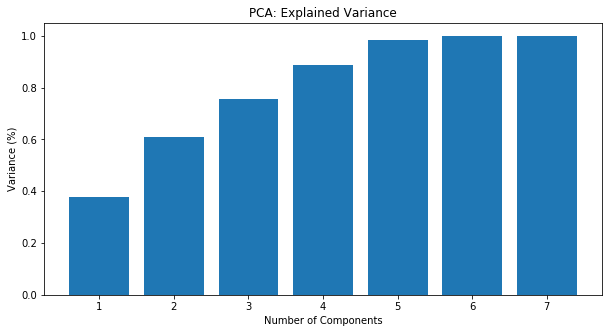

In [51]:
plt.figure(figsize=(10,5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1, 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA: Explained Variance')
plt.show()
plt.close()

In [52]:
pca = PCA(n_components=optimalNumberOfClusters);
feature_values_std_pca = pca.fit_transform(feature_values_std);
feature_values_std_pca = pd.DataFrame(feature_values_std_pca);
feature_values_std_pca.index = feature_values.index
feature_values_std_pca.head()

,0,1,2,3,4
0,-0.051838,0.016140,-0.145167,0.038136,0.028831
1,-0.039931,0.008522,-0.141139,0.047723,0.021285
2,-0.047869,0.015198,-0.142944,0.040758,0.035743
3,-0.049396,0.014958,-0.143743,0.040466,0.030276
4,-0.046095,0.014036,-0.140791,0.044408,0.036569


# Die Anzahl der Cluster bestimmen

**Frage:** Soll ich hier schon die nach PCA transformierten feature values verwenden? Im Folgenden treffe ich die Annahme, dass die nach PCA transformierten feature values verwendet werden sollten.

#### Funktionen

In [53]:
def estimateNumberOfClusters(feature_values, feature_values_std_pca, maxNumberOfClusters):
    scores = []
    numberOfCluster = []

    for i in range(2,maxNumberOfClusters,1):
        kmeans_tmp = KMeans(n_clusters=i)
        kmeans_tmp.fit(feature_values_std_pca)
        numberOfCluster.append(i)
        scores.append(metrics.calinski_harabasz_score(feature_values, kmeans_tmp.labels_))  
    
    result = pd.DataFrame(np.transpose(np.array([numberOfCluster, scores])).astype(int), columns=["Number of Clusters", "C.H. Score"]);
    optimalNumberOfClusters = numberOfCluster[np.argmax(scores)];
    
    return result, optimalNumberOfClusters;

In [54]:
def plotScores(scores):
    plt.figure()
    plt.bar(scores.iloc[:, 0],scores.iloc[:, 1] )
    plt.xlabel('Number of Clusters')
    plt.ylabel('C.H. Score') #for each component
    plt.title('Calinski Harabasz Score')
    plt.show()

In [55]:
scores = []
numberOfCluster = []
maxNumberOfClusters = 10

for i in range(2, maxNumberOfClusters, 1):
    kmeans_tmp = KMeans(n_clusters=i)
    kmeans_tmp.fit(feature_values_std_pca)
    numberOfCluster.append(i)
    scores.append(metrics.calinski_harabasz_score(feature_values, kmeans_tmp.labels_))  

results = pd.DataFrame(zip(numberOfCluster, scores), columns=["number_of_clusters", "calinski_score"])
optimalNumberOfClusters = results.loc[results["calinski_score"].idxmax()].astype(int)["number_of_clusters"]

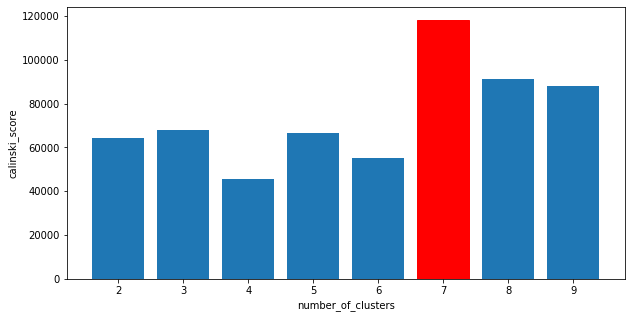

The optimal number of clusters is 7.


In [56]:
plt.figure(figsize=(10,5))
bars = plt.bar(x=results["number_of_clusters"], height=results["calinski_score"])
plt.xlabel(results.columns[0])
plt.ylabel(results.columns[1]) 
bars[results["calinski_score"].idxmax()].set_color("r")
plt.show()
plt.close()
print("The optimal number of clusters is {}.".format(optimalNumberOfClusters))

# Change optimal number manually

In [57]:
#  optimalNumberOfClusters = 4 # tmp

# Ausreißer eliminieren

**Todo**: *Prüfen in wie weit hierdurch wie bei Isolation Forest die exchange addresses rausgehauen werden.*

In [58]:

# def remove_outliers(feature_values, feature_values_std_pca, kmeans, threshold):
    
#     feature_values_std_pca_within_cluster_new = pd.DataFrame();
#     feature_values_within_cluster_new = pd.DataFrame();
#     labels_new = [];

#     for clusterNumber, centroid in enumerate(kmeans.cluster_centers_):
        
#         feature_values_std_pca_within_cluster = feature_values_std_pca[kmeans_opt.labels_ == clusterNumber];
#         feature_values_within_cluster = feature_values[kmeans_opt.labels_ == clusterNumber];
            
#         distances = feature_values_std_pca_within_cluster - centroid;
#         distances_norm = np.linalg.norm(distances, axis=1);

#         maxDistance = threshold * np.linalg.norm(feature_values_std_pca_within_cluster.std())
        
#         keep = distances_norm <= maxDistance
        
#         feature_values_std_pca_within_cluster_new = feature_values_std_pca_within_cluster_new.append(feature_values_std_pca_within_cluster[keep])
#         feature_values_within_cluster_new = feature_values_within_cluster_new.append(feature_values_within_cluster[keep])
#         labels_new.extend([clusterNumber for i in feature_values_within_cluster[keep].iterrows()])
        
#     return feature_values_std_pca_within_cluster_new, feature_values_within_cluster_new, labels_new

In [59]:
# kmeans_opt = KMeans(n_clusters=optimalNumberOfClusters)
# kmeans_opt.fit(feature_values_std_pca)

In [60]:
# from sklearn.metrics import calinski_harabaz_score as ch_score

# thresholds = np.linspace(.01,3, 20)

# test = [remove_outliers(feature_values, feature_values_std_pca, kmeans_opt,t) for t in thresholds]

# scores= []

# for (res1, res2, labels) in test:
#     scores.append(metrics.calinski_harabasz_score(res2, labels)) 

In [61]:
# plt.plot(thresholds, scores)
# plt.title('Calinski Harabaz Scores as std threshold changes')

In [62]:
# optimalThreshold = thresholds[np.argmax(scores)]
# print("The threshold leading to the highest Calinski Harabaz Score is", optimalThreshold)

In [63]:
# feature_values, feature_values_std_pca, labels = remove_outliers(feature_values, feature_values_std_pca, kmeans_opt, optimalThreshold)
# feature_values_std_pca = pd.DataFrame(feature_values_std_pca)
# feature_values = pd.DataFrame(feature_values)

# Visualisierung: T-SNE

In [64]:
# from sklearn.manifold import TSNE

# time_start = time.time()

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
# feature_values_std_pca_out_tsne = tsne.fit_transform(feature_values_std_pca_out)
# feature_values_std_pca_out_tsne = pd.DataFrame(feature_values_std_pca_out_tsne, columns=["1_tsne_comp","1_tsne_comp"])
# feature_values_std_pca_out_tsne.head()

# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [65]:
# # Plot Digits t-SNE
# import seaborn as sns

# # Set style of scatterplot
# sns.set_context("notebook", font_scale=1.1)
# sns.set_style("ticks")

# feature_values_std_pca_out_tsne["Label"] = kmeans_opt.labels_
# feature_values_std_pca_out_tsne.columns = ["x", "y", "Label"]

# sns.lmplot(x='x',
#            y='y',
#            data=feature_values_std_pca_out_tsne,
#            fit_reg=False,
#            legend=True,
#            height=9,
#            hue='Label',
#            scatter_kws={"s":200, "alpha":0.3})


# plt.title('t-SNE Results:', weight='bold').set_fontsize('14')
# plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
# plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')

## Visualisierung PCA 3D Diagramm

In [66]:
# from mpl_toolkits.mplot3d import Axes3D
# # To getter a better understanding of interaction of the dimensions
# # plot the first three PCA dimensions
# fig = plt.figure(figsize=(10, 10))
# ax = Axes3D(fig, elev=-150, azim=110)
# X_reduced = PCA(n_components=3).fit_transform(feature_values_out)
# ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=kmeans_opt.labels_,
#            cmap=plt.cm.Set1, edgecolor='k', s=40)
# ax.set_title("First three PCA directions")
# ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])
# ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])
# ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

In [67]:
kmeans_opt = KMeans(n_clusters=optimalNumberOfClusters)
kmeans_opt.fit(feature_values_std_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

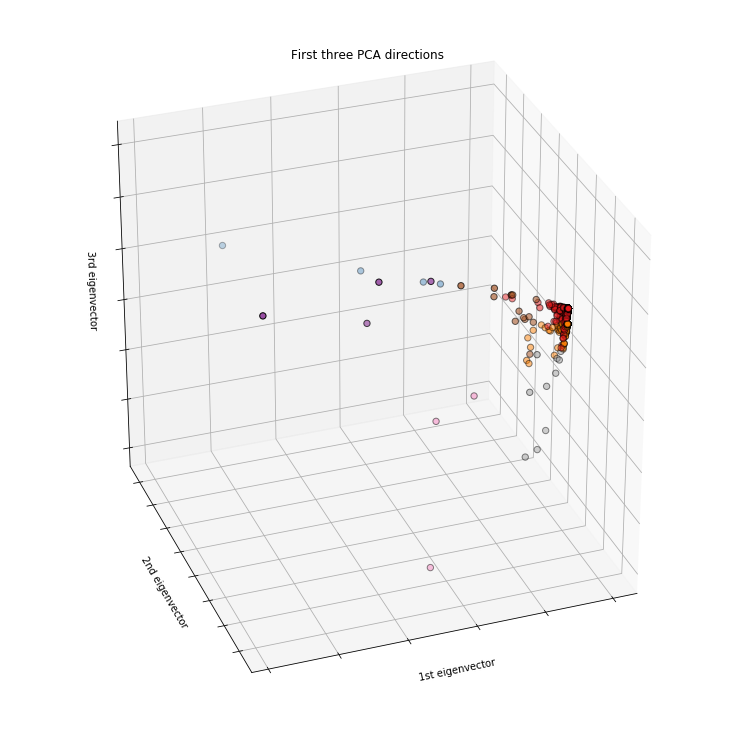

In [68]:
from mpl_toolkits.mplot3d import Axes3D;
# To getter a better understanding of interaction of the dimensions;
# plot the first three PCA dimensions;
fig = plt.figure(figsize=(10, 10));
ax = Axes3D(fig, elev=-150, azim=110);

scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
feature_values_std = scaler.fit_transform(feature_values);
feature_values_std = pd.DataFrame(feature_values_std, columns=feature_values.columns);
X_reduced = PCA(n_components=3).fit_transform(feature_values_std);


ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=kmeans_opt.labels_, cmap=plt.cm.Set1, edgecolor='k', s=40);
ax.set_title("First three PCA directions");
ax.set_xlabel("1st eigenvector");
ax.w_xaxis.set_ticklabels([]);
ax.set_ylabel("2nd eigenvector");
ax.w_yaxis.set_ticklabels([]);
ax.set_zlabel("3rd eigenvector");
ax.w_zaxis.set_ticklabels([]);

array([0, 3, 4, 6, 1, 2, 5])

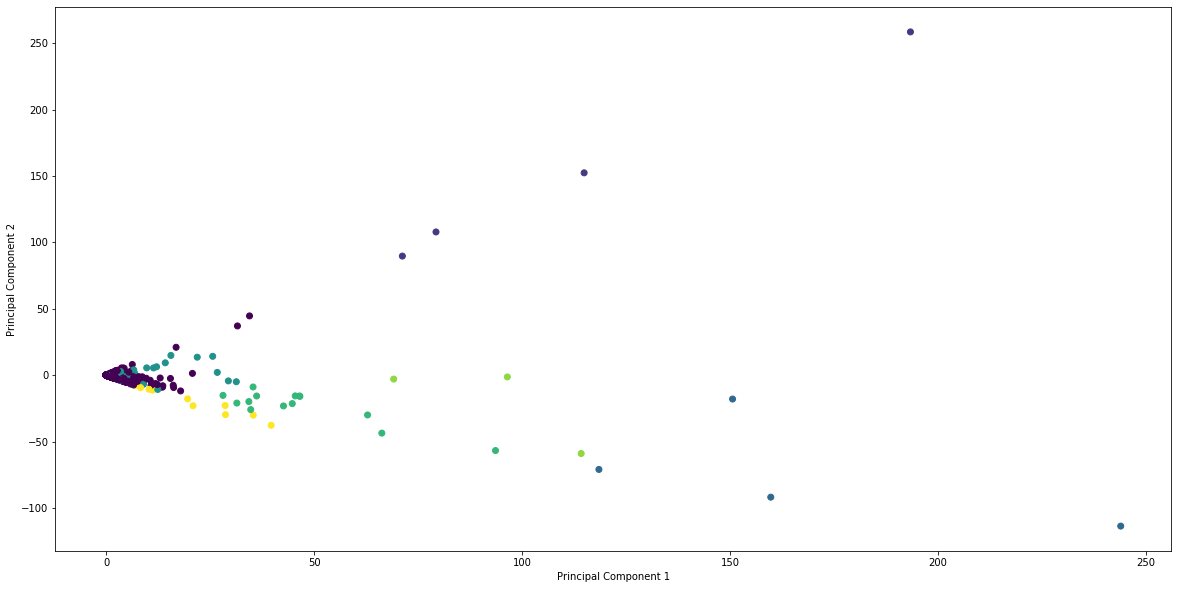

In [93]:
fig, ax = plt.subplots(figsize= (20,10))

scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
feature_values_std = scaler.fit_transform(feature_values);
feature_values_std = pd.DataFrame(feature_values_std, columns=feature_values.columns);
X_reduced = PCA(n_components=2).fit_transform(feature_values_std);

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_opt.labels_)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
pd.Series(kmeans_opt.labels_).unique()

In [95]:
snowflakes = pd.DataFrame(X_reduced, columns=["PC1", "PC2"]).idxmax()
for i in snowflakes:
    print(addresses[i])

0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be
0xea674fdde714fd979de3edf0f56aa9716b898ec8


# Vergleich der Ballungen

In [69]:
from collections import Counter
cluster_sizes = Counter(kmeans_opt.labels_)

cluster_data = {}

for cluster_label, cluster_size in cluster_sizes.most_common():
    feature_values_in_cluster = feature_values[kmeans_opt.labels_==cluster_label]
    cluster_data[cluster_label] = pd.Series([cluster_size], index=["cluster_size"])
    cluster_data[cluster_label] = cluster_data[cluster_label].append(feature_values_in_cluster.mean())
    
    
cluster_data = pd.DataFrame(cluster_data).T
# cluster_data["avgTimeDiffBetweenReceivedTransactions"] = [ timedelta(seconds=s) for s in cluster_data["avgTimeDiffBetweenReceivedTransactions"]]
# cluster_data["avgTimeDiffBetweenSentTransactions"] = [ timedelta(seconds=s) for s in cluster_data["avgTimeDiffBetweenSentTransactions"]]
cluster_data["cluster_size"] = cluster_data["cluster_size"].astype("int")

# Vergleich der Ballungen durch Visualisierung

In [70]:
cluster_data.sum(axis=0)

cluster_size                    1.000000e+05
balance                         2.400689e+24
weiReceived                     8.492457e+25
weiSent                         8.260340e+25
numberOfTranscationsReceived    1.460133e+07
numberOfTranscationsSent        1.970375e+07
mined_blocks                    1.272619e+06
is_contract                     2.485714e+00
dtype: float64

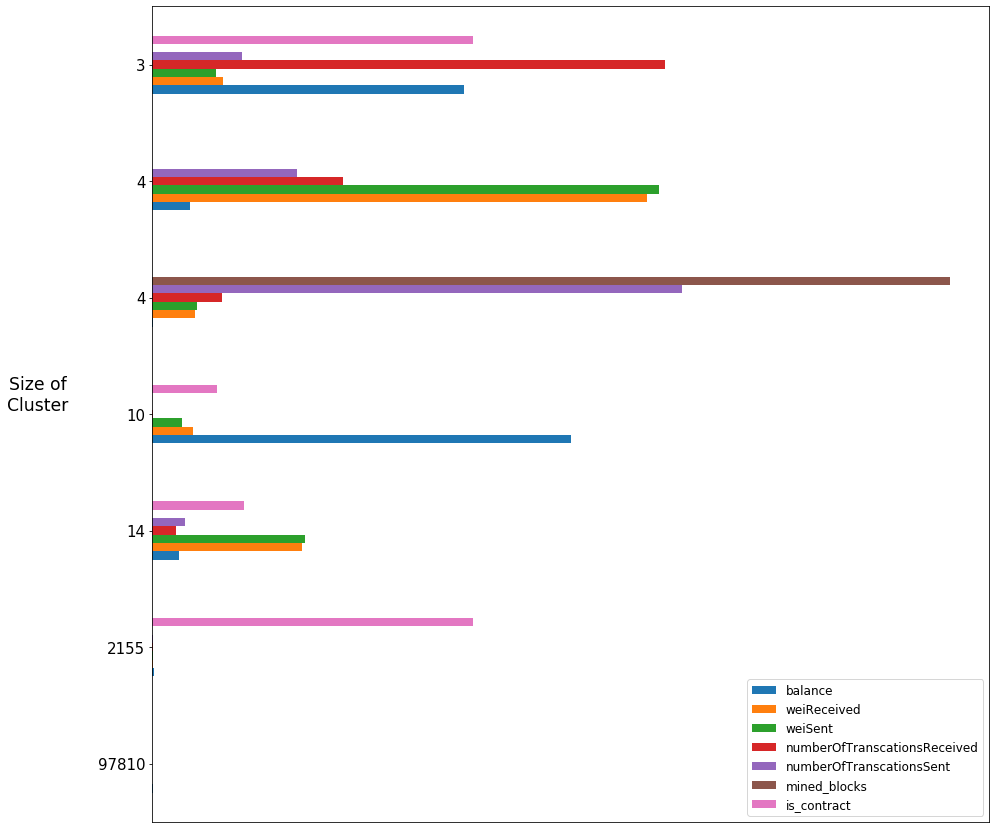

In [71]:
cluster_data_for_plot1 = cluster_data.drop(columns=["cluster_size"])
cluster_data_for_plot1 = cluster_data_for_plot1 / cluster_data_for_plot1.sum()
cluster_data_for_plot1["cluster_size"] = cluster_data["cluster_size"]
# cluster_data_for_plot1 = cluster_data_for_plot1.reset_index()

ax = cluster_data_for_plot1.plot.barh(x="cluster_size" ,figsize=(15,15))

ax.tick_params(
    which="major",
    axis='x', 
    bottom=False
    )

ax.tick_params(
    which="major",
    axis='y', 
    labelsize=15
    ) 

ylabels = ax.get_yticklabels()

ax.legend(loc="lower right", fontsize="larger")

ax.set_xticklabels([])
ylabel = ax.set_ylabel("Size of\nCluster", fontsize="xx-large", rotation=0, labelpad=60)

In [72]:
cluster_data_for_plot1

,balance,weiReceived,weiSent,numberOfTranscationsReceived,numberOfTranscationsSent,mined_blocks,is_contract,cluster_size
0,0.000332,0.000044,0.000036,0.000021,0.000024,0.000015,0.000000,97810
3,0.001628,0.000249,0.000209,0.001075,0.000713,0.000000,0.402299,2155
4,0.033287,0.187172,0.191452,0.029984,0.041119,0.000000,0.114943,14
6,0.525501,0.050976,0.037135,0.000149,0.000005,0.000000,0.080460,10
1,0.001035,0.052921,0.055435,0.087243,0.663988,0.999985,0.000000,4
2,0.047009,0.620155,0.636132,0.238792,0.181694,0.000000,0.000000,4
5,0.391208,0.088484,0.079600,0.642735,0.112457,0.000000,0.402299,3


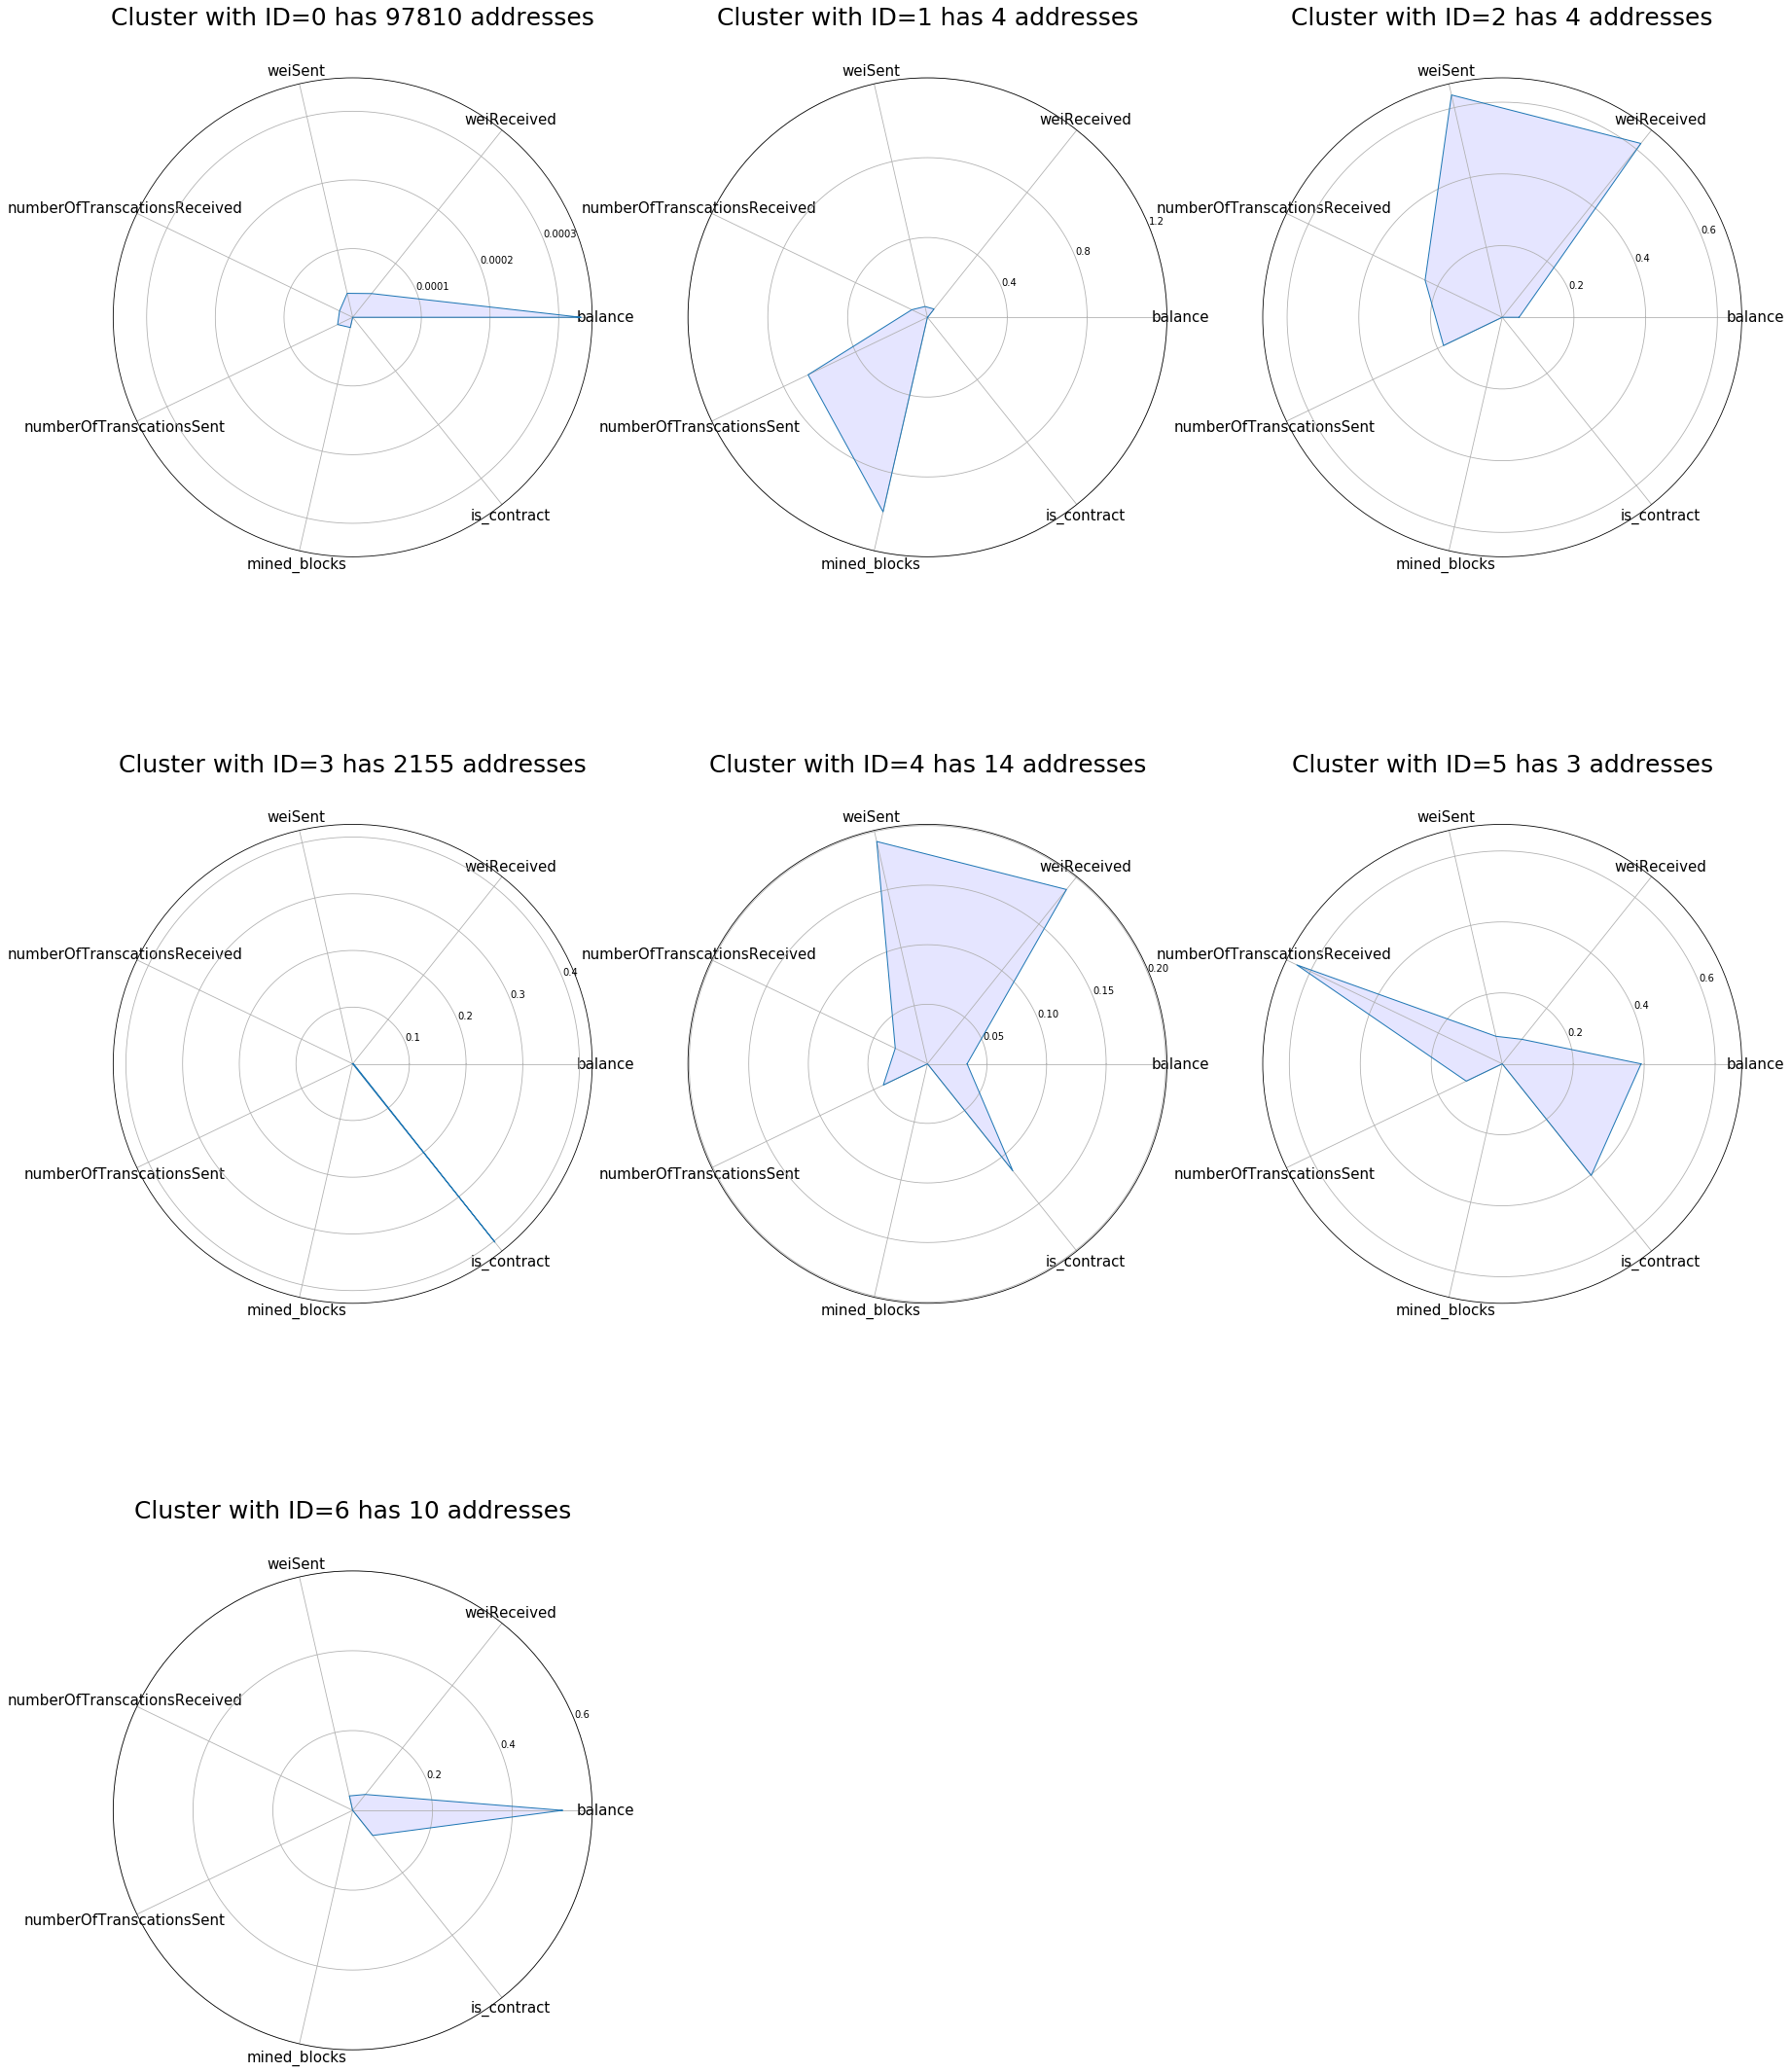

In [96]:
from math import pi

cluster_data_for_plot2 = cluster_data_for_plot1.copy()
cluster_data_for_plot2 = cluster_data_for_plot2.drop(columns=["cluster_size"])
cluster_data_for_plot2 = cluster_data_for_plot2.sort_index()
# cluster_data_for_plot2 = cluster_data_for_plot2.set_index("index")

categories=list(cluster_data_for_plot2)
N = len(categories)

values = {}

for i,v in cluster_data_for_plot2.iterrows(): 
    tmp_values = cluster_data_for_plot2.loc[i].values.tolist()
    tmp_values += tmp_values[:1]
    values[i] = tmp_values

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
angles
 
plt.figure(figsize=(30,40))

for cluster_label, cluster_values in values.items():
    position = int("".join([str(33), str(cluster_label + 1)]))
    axis = plt.subplot(position, polar=True)
    plt.sca(axis)
    plt.xticks(angles[:-1], categories, size=15)

#     plt.ylim(top=1)

    axis.plot(angles, cluster_values, linewidth=1, linestyle='solid')
    axis.fill(angles, cluster_values, 'b', alpha=0.1)
#     a.text(0.1,0.1, cluster_size[i], color = "red", size=20)
    axis.set_title("Cluster with ID={} has {} addresses".format(cluster_label, cluster_sizes[cluster_label]), color = "black", size=25, loc="center", pad=30)
    axis.set_yticks([t for i,t in enumerate(axis.get_yticks()) if i%2!=0])

In [97]:
yticks = axis.get_yticks()
print(yticks)
newyticks = [t for i,t in enumerate(yticks) if i%2==0]
newyticks
# axis.set_yticks()

[0.2 0.4 0.6]


[0.2, 0.6000000000000001]

In [98]:
for i,cd in cluster_data.iterrows():
    x = addresses[kmeans_opt.labels_==i]
    print("Length of cluster with id={}: {}".format(i, len(x)))
    display(x)
    print("############################")

Length of cluster with id=0: 97810


0        0xda727b5497201ef350c557a557c88f0f14195380
1        0x00aadc5a01edeeebdfc3733b3755cff81160ca06
2        0xf91705266175ed5112fd86ff00299057a1c918b9
3        0xb39add9a30c9313975cf9933f689b7d57cb76eb3
4        0xe69e9f45317ccb4dcc41295688cf1bac16aa9637
                            ...                    
99995    0x000e2efc022f5981b6ac8b05d75c97bc809b0fb0
99996    0xa1391dd96881802ff23dfcbe409e83318f2d477b
99997    0x970df29a8ac5217c1540f296cdf57bbdbfe371a0
99998    0x093baca185fa5a01a2b3cb38ea4ac7e2cd3f3f49
99999    0x47c4d877cd4a611da9b9b806033202973a41b37c
Name: address, Length: 97810, dtype: object

############################
Length of cluster with id=3: 2155


5        0xdfc9b97ab528718f5b1e855dcfa03558f37af496
46       0x74d4344bf8cead0779e2041f19d2985985c67d7b
116      0x7c4b4bb0bb0fadbcb1c54ed55a3b4f1d456726c6
117      0x607d7751d9f4845c5a1de9eed39c56f4fc0f855d
163      0x920de9f1ef49bac275015c3db6360fcefeb5d841
                            ...                    
99546    0xe4c00cfd4aa493ad890ef83ad9d643a788b17bd9
99605    0x7671f9c37bfcee829f54d4bdd2a226930c91df7b
99864    0x17eb0b85af8f4c68539e73ee04433b6cce0777ab
99942    0xd31a34d621122bebe0dee360e33bbe61193d5b90
99961    0xae7a1b1ba864696bcdcec94a34fb5836ca9a3910
Name: address, Length: 2155, dtype: object

############################
Length of cluster with id=4: 14


1361     0x6cc5f688a315f3dc28a7781717a9a798a59fda7b
5229     0x0681d8db095565fe8a346fa0277bffde9c0edbbf
5246     0x167a9333bf582556f35bd4d16a7e80e191aa6476
8245     0x1522900b6dafac587d499a862861c0869be6e428
9276     0xd551234ae421e3bcba99a0da6d736074f22192ff
10126    0xd24400ae8bfebb18ca49be86258a3c749cf46853
10503    0x70faa28a6b8d6829a4b1e649d26ec9a2a39ba413
11383    0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae
15094    0x564286362092d8e7936f0549571a803b203aaced
15329    0xbf4ed7b27f1d666546e30d74d50d173d20bca754
15512    0x2910543af39aba0cd09dbb2d50200b3e800a63d2
17002    0x0d0707963952f2fba59dd06f2b425ace40b492fe
17858    0xd94c9ff168dc6aebf9b6cc86deff54f3fb0afc33
18878    0xbb9bc244d798123fde783fcc1c72d3bb8c189413
Name: address, dtype: object

############################
Length of cluster with id=6: 10


3772     0x61edcdf5bb737adffe5043706e7c5bb1f1a56eea
4066     0x53d284357ec70ce289d6d64134dfac8e511c8a3d
5332     0xdc76cd25977e0a5ae17155770273ad58648900d3
9877     0xe853c56864a2ebe4576a807d26fdc4a0ada51919
11599    0x742d35cc6634c0532925a3b844bc454e4438f44e
13921    0x229b5c097f9b35009ca1321ad2034d4b3d5070f6
15745    0xbe0eb53f46cd790cd13851d5eff43d12404d33e8
18093    0xab7c74abc0c4d48d1bdad5dcb26153fc8780f83e
93313    0x66f820a414680b5bcda5eeca5dea238543f42054
94651    0x997114ca0830e9bee7443368fa27f4af2d4e55a6
Name: address, dtype: object

############################
Length of cluster with id=1: 4


5106     0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5
7729     0xea674fdde714fd979de3edf0f56aa9716b898ec8
12038    0x829bd824b016326a401d083b33d092293333a830
19393    0x2a65aca4d5fc5b5c859090a6c34d164135398226
Name: address, dtype: object

############################
Length of cluster with id=2: 4


5231     0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98
7487     0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be
13310    0x876eabf441b2ee5b5b0554fd502a8e0600950cfa
15511    0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0
Name: address, dtype: object

############################
Length of cluster with id=5: 3


9278     0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
13097    0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208
16313    0x8d12a197cb00d4747a1fe03395095ce2a5cc6819
Name: address, dtype: object

############################


In [116]:
any(addresses.str.contains("0x5A0b54D5dc17e0AadC383d2db43B0a0D3E029c4c", case=False))

False

# Helper functions to analyse data

In [ ]:
def open_etherscan(cluster_id, number_of_addresses):
    if len(addresses[kmeans_opt.labels_==cluster_id]) > number_of_addresses:
        for a in np.random.choice(addresses[kmeans_opt.labels_==cluster_id], number_of_addresses):
            webbrowser.open('https://etherscan.io/address/{}'.format(a), new=2)
    else:
        for a in addresses[kmeans_opt.labels_==cluster_id]:
            webbrowser.open('https://etherscan.io/address/{}'.format(a), new=2)
    
open_etherscan(8, 5)
# open_etherscan(2, 5)

In [ ]:
cluster_data

# Recall, Precision und F1 score für das Clustering

In [ ]:
# exchanges = [(a, "e") for i, a in enumerate(addresses) if a.startswith("exchange")]
# speculators = [(a, "x") for i, a in enumerate(addresses) if a.startswith("speculator")]

# exchanges = pd.DataFrame(zip(*exchanges)).T
# speculators = pd.DataFrame(zip(*speculators)).T

# exchanges.columns = ["address", "should_actual_be_in_cluster"]
# speculators.columns = ["address", "should_actual_be_in_cluster"]

# exchanges = exchanges.set_index("address")
# speculators = speculators.set_index("address")

# # addresses[kmeans_opt.labels_ == 2]

# tmp = pd.DataFrame(zip(addresses, kmeans_opt.labels_), columns=["address", "is_in_cluster"])
# tmp = tmp.set_index("address")

# tmp1 = exchanges.append(speculators)

# tmp1 = tmp1.join(tmp, on="address", how="inner")

# cluster_list = []
# for i in tmp1["is_in_cluster"].unique():
#     cluster_list.append(list(tmp1[tmp1["is_in_cluster"] == i]["should_actual_be_in_cluster"]))



In [ ]:
# import collections as collections
# from math import factorial as fac

# def b(x, y):
#     try:
#         binom = fac(x) // fac(y) // fac(x - y)
#     except ValueError:
#         binom = 0
#     return binom

# Counter = collections.Counter

# num_doc= 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     TP += b(c["e"], 2) 
    
# # Calculate False Positives
    
# for c in range(0, len(cluster_list)): 
#     c = Counter(cluster_list[c])
#     FP += c["e"] * c["x"]

# # Add all the cluster together
# sum = Counter()
# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 

#     fn_temp += ct["e"]*(sum["e"]-ct["e"])
#     sum -= ct
#     FN += fn_temp


# print("num_doc is %d " % num_doc)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)



In [ ]:
# fig, ax = plt.subplots(figsize= (20,10))

# cluster_list.sort(key=len, reverse = True)
# ind = range(0, len(cluster_list))

# numberOfExchanges = [Counter(cl)["e"] for cl in cluster_list]
# numberOfSpeculators = [Counter(cl)["x"] for cl in cluster_list]

# line1 = ax.barh(ind, numberOfExchanges)
# line2 = ax.barh(ind, numberOfSpeculators, left=numberOfExchanges)

# yticklabels = ax.get_yticklabels()

# start, end = ax.get_ylim()
# ax.set_ylim(-1,7)

# ax.yaxis.set_ticks(np.arange(0, 7, 1))

# ax.legend((line1, line2), ('Exchanges', 'Unkown'), loc="upper right", fontsize="larger")

# yticklabels = ax.set_yticklabels(ind)

# ax.tick_params(
#     which="major",
#     axis='both', 
#     labelsize=13
#     ) 
# ylabel = ax.set_ylabel("Cluster-ID", fontsize="xx-large", rotation=0, labelpad=60)
# ylabel = ax.set_xlabel("Number of Addresses", fontsize="xx-large", rotation=0, labelpad=30)


# Temporary stuff

In [ ]:
# import collections as collections

# Counter = collections.Counter

# cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
# num_doc= 0
# positives = 0
# negatives = 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     # calculating positives...
#     positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

#     # calculating TP...
#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     tp_temp = 0 
#     for k,v in dict(c).items():
#         if v>1:
#             tp_temp += (v*(v-1))/2
#     TP += tp_temp 

# FP = positives - TP
# negatives = ((num_doc*(num_doc-1))/2) - positives
# # Add all the cluster together
# sum = Counter()

# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 
#     for k,v in dict(ct).items():
#         fn_temp += v*(sum[k]-v)
#     sum -= ct
#     FN += fn_temp
# TN = negatives -FN
# print("num_doc is %d " % num_doc)
# print("positives is %d " % positives)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)

Problem: Mit dem obigen Algorithmus wird die Güte des Clustering Algorithmus ingesamt bestimmt. Ich will aber nur die Güte des Clustering Modell anhand der Exchange Adressen bestimme.

Lösung?: (#Paare im selben cluster) / (#Paare in unterschiedlichen Clustern)

In [ ]:
# import collections as collections

# Counter = collections.Counter

# cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
# num_doc= 0
# positives = 0
# negatives = 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     # calculating positives...
#     positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

#     # calculating TP...
#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     tp_temp = 0 
#     for k,v in dict(c).items():
#         if v>1:
#             tp_temp += (v*(v-1))/2
#     TP += tp_temp 

# FP = positives - TP
# negatives = ((num_doc*(num_doc-1))/2) - positives
# # Add all the cluster together
# sum = Counter()

# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 
#     for k,v in dict(ct).items():
#         fn_temp += v*(sum[k]-v)
#     sum -= ct
#     FN += fn_temp
# TN = negatives -FN
# print("num_doc is %d " % num_doc)
# print("positives is %d " % positives)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)